In [1]:
# import libraries

In [2]:
#importing libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import colors
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,roc_auc_score,roc_curve
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,f1_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import Pool, CatBoostClassifier 
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None

%matplotlib inline

In [3]:
!pip install xgboost

In [4]:
!pip install catboost

In [5]:
train=pd.read_csv('train.csv')
df=train.copy()
test=pd.read_csv('test.csv')
df_test=test.copy()

In [6]:
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.60,309.60,1596,36.10,140,0,0,0,0,0,0
1,1,M20343,M,302.60,312.10,1759,29.10,200,0,0,0,0,0,0
2,2,L49454,L,299.30,308.50,1805,26.50,25,0,0,0,0,0,0
3,3,L53355,L,301.00,310.90,1524,44.30,197,0,0,0,0,0,0
4,4,M24050,M,298.00,309.00,1641,35.40,34,0,0,0,0,0,0


# Dataset Description
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Machine Failure Predictions. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.
# Files
train.csv - the training dataset; Machine failure is the (binary) target (which, in order to align with the ordering of the original dataset, is not in the last column position)
test.csv - the test dataset; your objective is to predict the probability of Machine failure

## EXPLORATORY DATA ANALYSIS

In [7]:
# 1. Exploratory Data Analysis:

def check_df(df):
    print("##################### Shape #####################")
    print(df.shape)
    print("##################### Types #####################")
    print(df.dtypes)
    print("##################### Head #####################")
    print(df.head(3))
    print("##################### Tail #####################")
    print(df.tail(3))
    print("##################### Null values #####################")
    print(df.isnull().sum())
    print("##################### Quantiles #####################")
    print(df.describe().T)
    print("##################### Unique #####################")
    print(df.nunique())
    print("##################### Columns #####################")
    print(df.columns)

check_df(df)

##################### Shape #####################
(136429, 14)
##################### Types #####################
id                           int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object
##################### Head #####################
   id Product ID Type  Air temperature [K]  Process temperature [K]  \
0   0     L50096    L               300.60                   309.60   
1   1     M20343    M               302.60                   312.10   
2   2     L49454    L               299.30                   308.50   

   Rotational speed [rpm]  Torque [Nm]  Tool wear

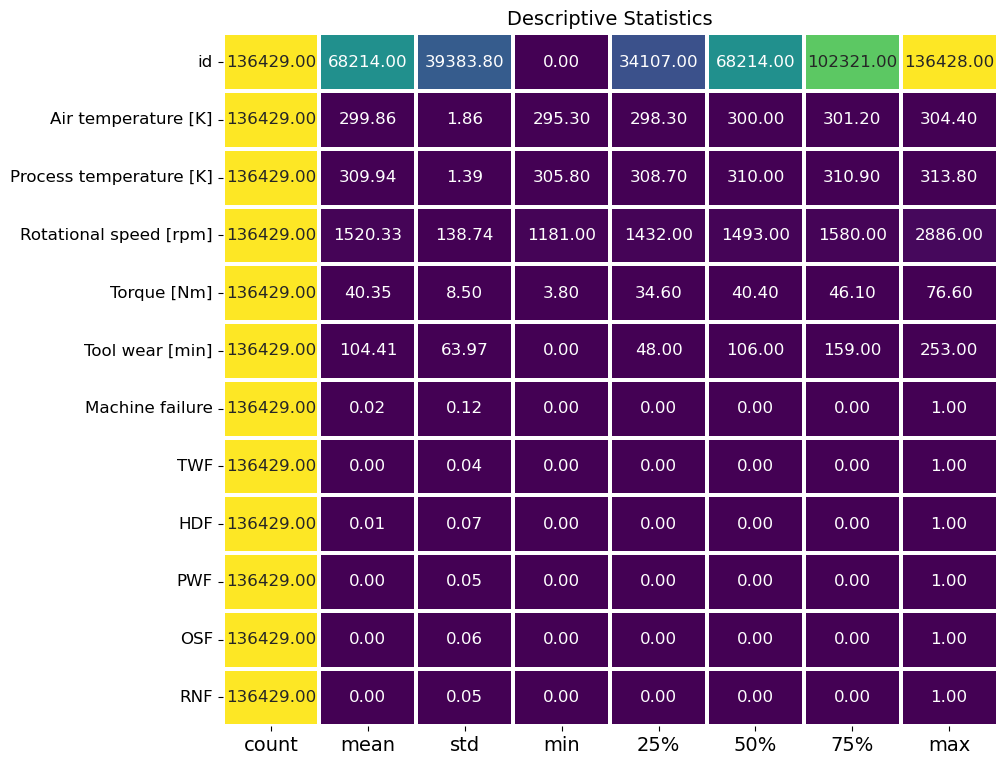

In [8]:
# describe stats of the data
cols=df.select_dtypes(include=['float64','int64'])
cmap1 = 'viridis'
def desc_stats(dataframe):
    desc = dataframe.describe().T
    f,ax = plt.subplots(figsize=(10,
                                 desc.shape[0] * 0.75))
    sns.heatmap(desc,
                annot = True,
                cmap = cmap1,
                fmt= '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.5,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 14)
    plt.yticks(size = 12,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(cols)

In [9]:
# grabbing numeric and categorical columns:
def cat_num_cols(dataframe,cat_th=12,car_th=20):
    
    # categorical columns
    cat_cols=[col for col in dataframe.columns if dataframe[col].dtypes=="O"]
    
    # numerical columns
    num_cols=[col for col in dataframe.columns if dataframe[col].dtypes!="O"]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
 
    
    return cat_cols,num_cols

cat_cols,num_cols=cat_num_cols(df)

Observations: 136429
Variables: 14
cat_cols: 2
num_cols: 12


In [10]:
# distribution of categorical variables
colors = ['#7DBCE6','#EEBDEE','#EAEAAF','#8FE195','#E28181',
          '#87D8DB','#C2E37D','#DF93A4','#DCB778','#C497DE']

cat_cols=[col for col in df.columns if df[col].dtypes=="O" and col not in "Product ID"]

def cat_summary(dataframe, col):
    print(pd.DataFrame({col:df[col].value_counts(),
                       "Ratio":100*df[col].value_counts()/len(df)}))

    fig = make_subplots(rows=1,cols=1,
                        subplot_titles=('Distribution'))
    fig.add_trace(go.Bar(x=dataframe[col].value_counts().index,
                            y=dataframe[col].value_counts().values,
                            marker=dict(color=colors)),row=1,col=1)
    
    
  
    fig.update_layout(title = {'text': col,
                               'y':0.9,
                               'x':0.5,
                               'xanchor': 'center',
                               'yanchor': 'top'},
                      template = "plotly_dark",width=400,height=400)
    
    iplot(fig) # to show the plot in notebook with optimized design

for i in cat_cols:
    cat_summary(df,i)

       Type  Ratio
Type              
L     95354  69.89
M     32152  23.57
H      8923   6.54


## FEATURE EXTRACTION

In [11]:
df["Power"] = df["Torque [Nm]"] * df["Rotational speed [rpm]"]
df_test["Power"] = df_test["Torque [Nm]"] * df_test["Rotational speed [rpm]"]

df["Failure_Sum"] = df["HDF"] + df["OSF"] + df["PWF"] +df["TWF"] + df["RNF"]
df_test["Failure_Sum"] = df_test["HDF"] + df_test["OSF"] + df_test["PWF"] + df_test["TWF"] + df_test["RNF"]

## FILLING MISSING VALUES

In [12]:
# show the missing values in dataset with ratio
def missing_values_tabl(df):
    
    na_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (df[na_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=['n_miss', 'ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

missing_values_tabl(df)
missing_values_tabl(df_test)

,n_miss,ratio


## DATA VISUALIZATION

Text(0.5, 1.0, 'Correlation Between Features')

<Figure size 4000x2000 with 0 Axes>

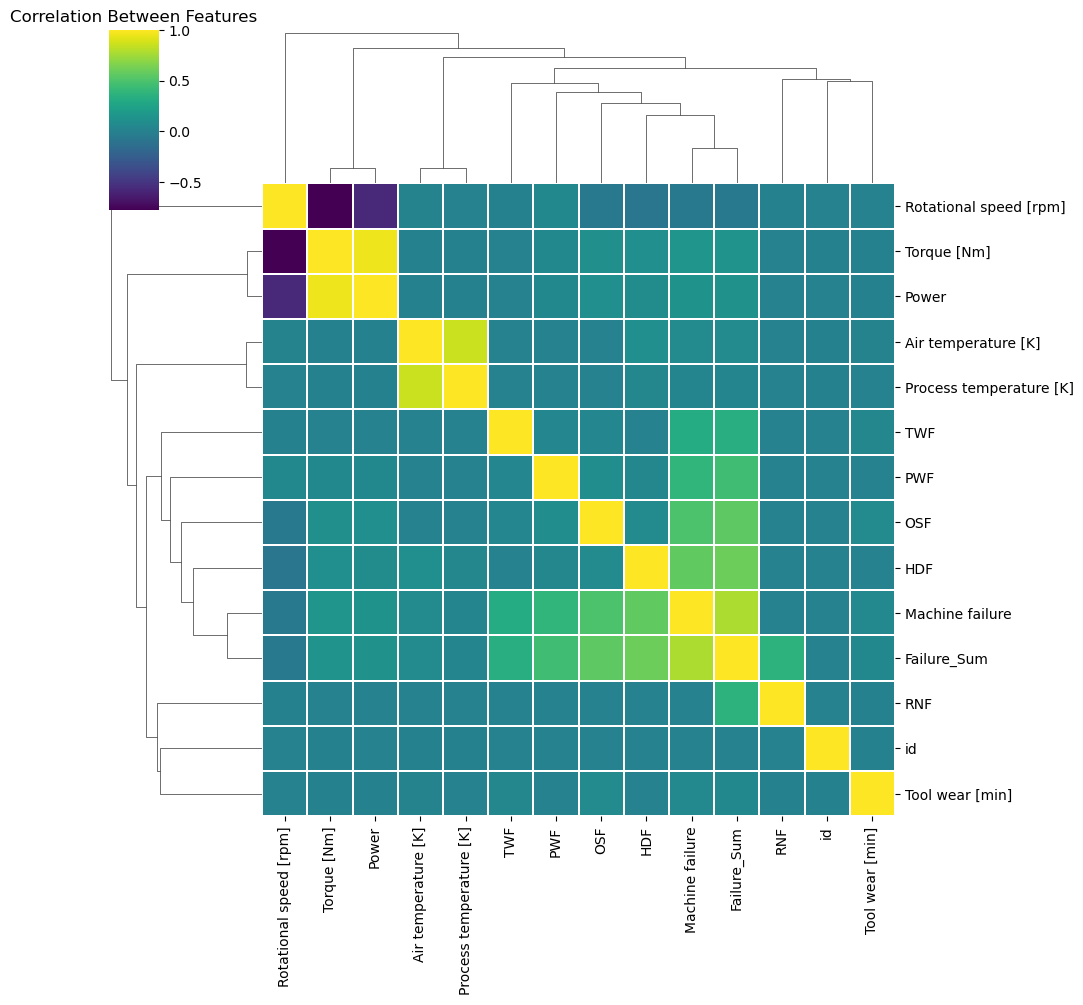

In [13]:
# check the correlation between the features
num_cols=[col for col in df.columns if df[col].dtypes!="O"]

# correlation matrix:
corr=df[num_cols].corr()
plt.figure(figsize=(40,20))
sns.clustermap(corr,cmap="viridis",linewidths=0.3,fmt=".2f")
plt.title("Correlation Between Features")

In [14]:
# pairplot of the selected features

# cols=[col for col in df.columns if col not in ["Product ID","id"]]

# plt.figure(figsize=(20,20))
# sns.set_style("darkgrid")
# sns.pairplot(df[cols],kind="reg",diag_kind="kde",palette="husl",hue="Type");
# plt.title("Distribution of all Variables")

## OUTLIER DETECTION

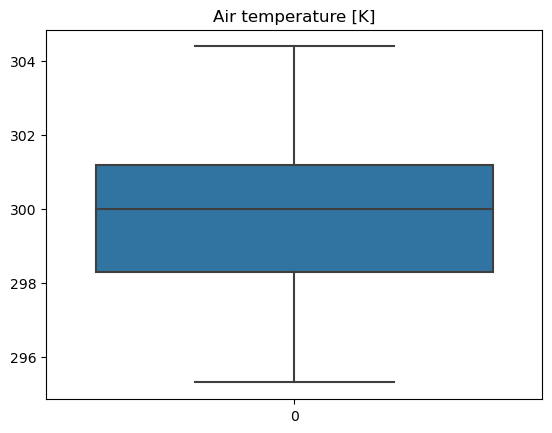

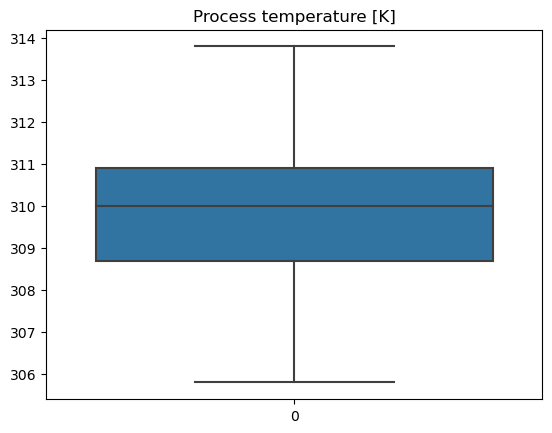

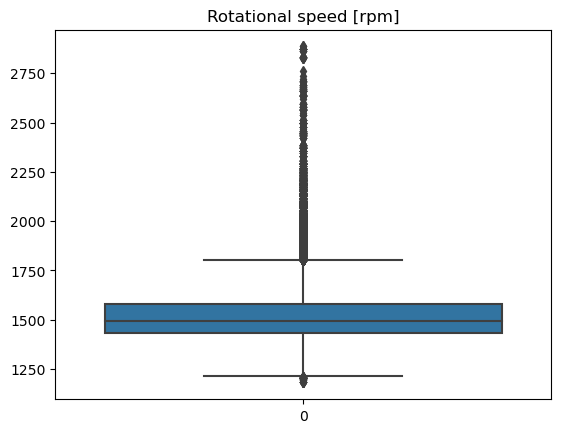

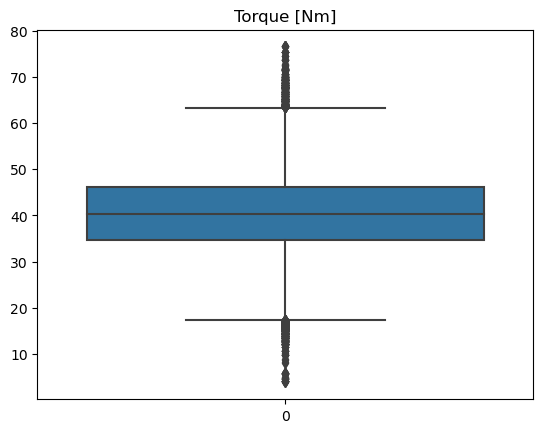

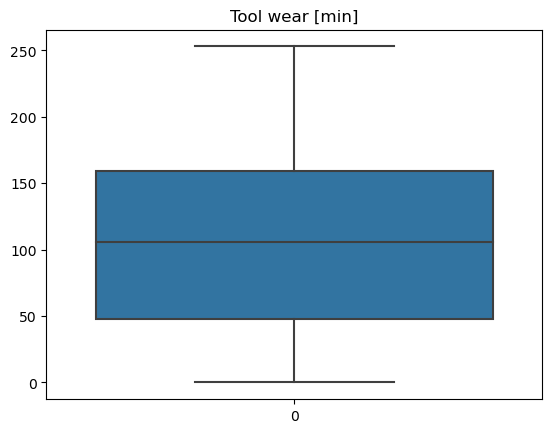

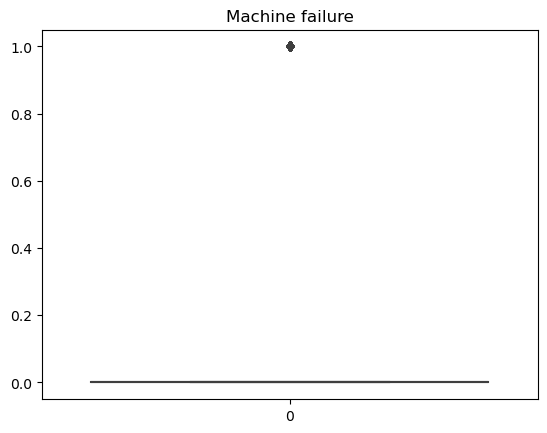

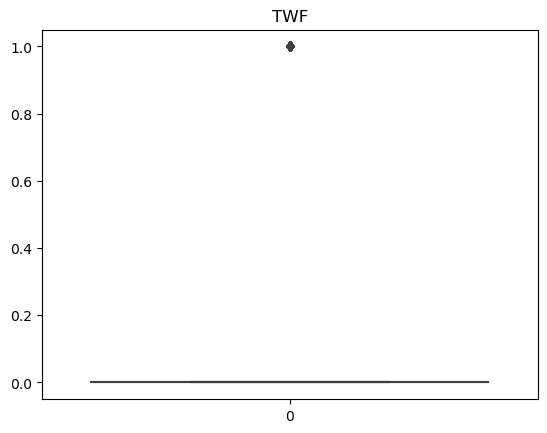

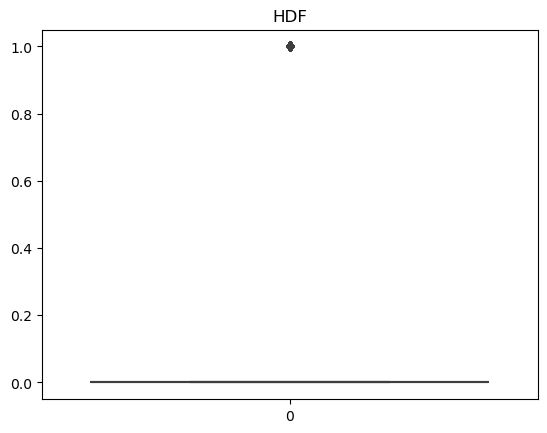

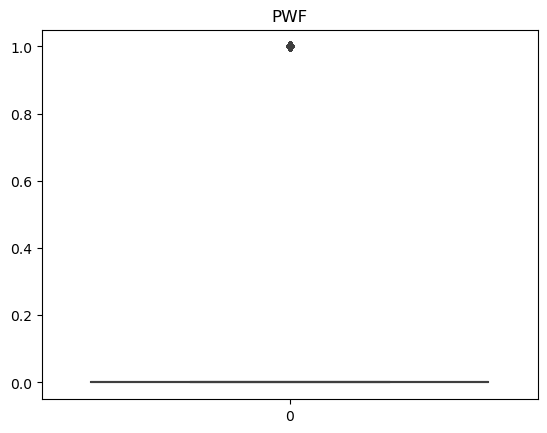

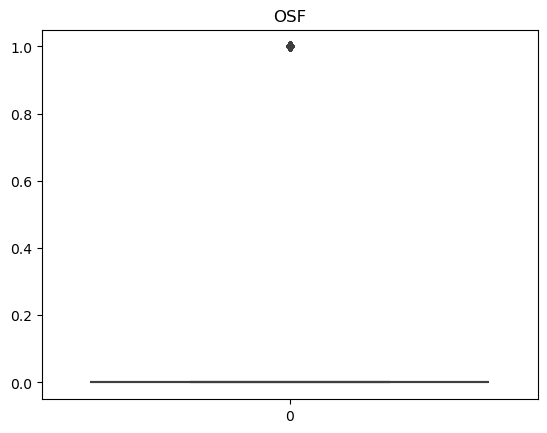

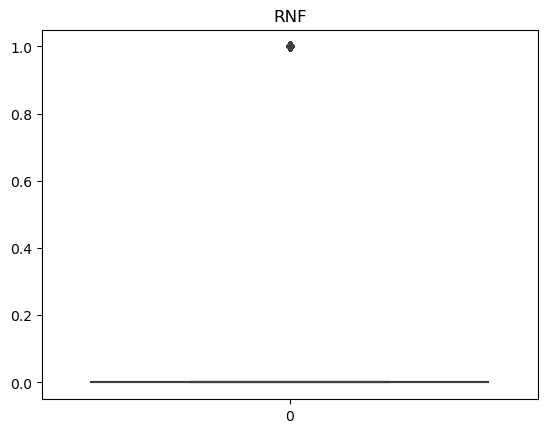

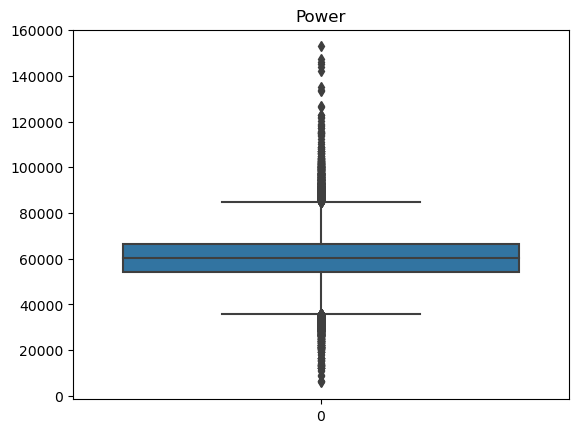

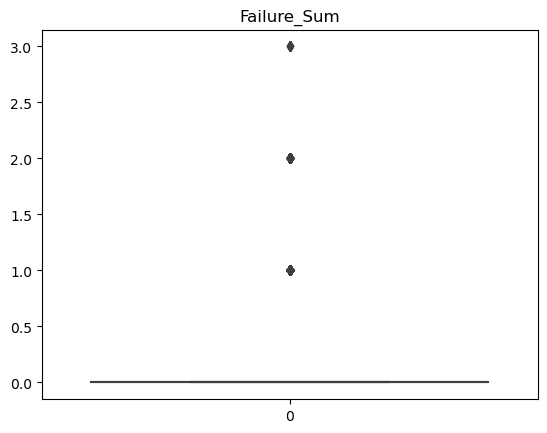

In [15]:
# showing outliers with boxplot in the dataset
num_cols=[col for col in df.columns if df[col].dtypes!="O" and col not in ["id","Product ID"]]
for i in df[num_cols].columns:
    sns.boxplot(df[i])
    plt.title(i)
    plt.show()

In [16]:
# # Outlier Thresholds


# num_cols=[col for col in df.columns if df[col].dtypes!="O" and col not in ["id","Product ID","Machine failure"]]
# # #  outlier threshold:
# def outlier_thresholds(dataframe,col_name,q1=0.02,q3=0.98):
#     q1=dataframe[col_name].quantile(q1)
#     q3=dataframe[col_name].quantile(q3)
#     IQR=q3-q1
    
#     up_limit=q3+1.5*IQR
#     low_limit=q1-1.5*IQR
    
#     return low_limit,up_limit

# # # check outliers:
# # # eğer değişkende aykırı değer varsa True döndürür, yoksa False döndürür.
# def check_outliers(dataframe,col_name):
#     low_limit,up_limit=outlier_thresholds(dataframe,col_name)
#     if dataframe[(dataframe[col_name]<low_limit) | (dataframe[col_name]>up_limit)].any(axis=None):
#          return True 
   
#     else:
#          return False
    
# def replace_with_thresholds(dataframe, col):
#     low_limit, up_limit = outlier_thresholds(dataframe, col)
#     if low_limit > 0:
#         dataframe.loc[(dataframe[col] < low_limit), col] = low_limit
#         dataframe.loc[(dataframe[col] > up_limit), col] = up_limit
#     else:
#         dataframe.loc[(dataframe[col] > up_limit), col] = up_limit   
        
# for col in num_cols:
#      print(col, check_outliers(df, col))

# for col in num_cols:
#     replace_with_thresholds(df, col)
#     replace_with_thresholds(df_test, col)
# print("After filling with thresholds:")
# for col in num_cols:
#     print(col,check_outliers(df,col))

## FEATURE ENGINEERING

In [17]:
# LABEL ENCODING:
le = LabelEncoder()


def label_encoder(df, column_name):
    if df[column_name].dtype == 'object' and column_name not in ["Product ID","id"]:
        if df[column_name].nunique() <= 2:
            le = LabelEncoder()
            df[column_name] = le.fit_transform(df[column_name])
            return df
        elif df[column_name].nunique() > 2  and df[column_name].nunique() <= 10:
            ohe = OneHotEncoder()
            ohe_df = pd.DataFrame(ohe.fit_transform(df[[column_name]]).toarray())
            ohe_df.columns = [column_name + "_" + str(i) for i in ohe_df.columns]
            df = df.join(ohe_df)
            df = df.drop(column_name, axis=1)
            return df
        else:
            return df
        
    else:
        return df
    

for i in df.columns:
    df = label_encoder(df, i)
    
for i in df_test.columns:
    df_test=label_encoder(df_test,i)
    
    
df.head(10)

,id,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Power,Failure_Sum,Type_0,Type_1,Type_2
0,0,L50096,300.60,309.60,1596,36.10,140,0,0,0,0,0,0,57615.60,0,0.00,1.00,0.00
1,1,M20343,302.60,312.10,1759,29.10,200,0,0,0,0,0,0,51186.90,0,0.00,0.00,1.00
2,2,L49454,299.30,308.50,1805,26.50,25,0,0,0,0,0,0,47832.50,0,0.00,1.00,0.00
3,3,L53355,301.00,310.90,1524,44.30,197,0,0,0,0,0,0,67513.20,0,0.00,1.00,0.00
4,4,M24050,298.00,309.00,1641,35.40,34,0,0,0,0,0,0,58091.40,0,0.00,0.00,1.00
5,5,M24300,298.40,308.90,1429,42.10,65,0,0,0,0,0,0,60160.90,0,0.00,0.00,1.00
6,6,L56736,299.60,311.00,1413,42.90,156,0,0,0,0,0,0,60617.70,0,0.00,1.00,0.00
7,7,L55488,298.70,310.10,1609,38.10,67,0,0,0,0,0,0,61302.90,0,0.00,1.00,0.00
8,8,L56397,297.70,308.80,1578,35.20,13,0,0,0,0,0,0,55545.60,0,0.00,1.00,0.00
9,9,L55067,300.50,312.30,1447,53.30,98,0,0,0,0,0,0,77125.10,0,0.00,1.00,0.00


## DATA PREPROCESSING

In [18]:
df1=df.drop(["Product ID","id"],axis=1)

X=df1.drop(["Machine failure"],axis=1).values
y=df1["Machine failure"].values.reshape(-1,1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)
print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (109143, 15)
X_test shape:  (27286, 15)
y_train shape:  (109143, 1)
y_test shape:  (27286, 1)


In [19]:
df_test=df_test.drop(["Product ID","id"],axis=1)

sc=StandardScaler()
sc1=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

df_test=sc1.fit_transform(df_test)

## DATA MODELING AND EVALUATING

In [20]:
# MODELING:

knn=KNeighborsClassifier()
svc=SVC(random_state=42)
nb=GaussianNB()
dtc=DecisionTreeClassifier(random_state=42)
rfc=RandomForestClassifier(random_state=42)
xgb=XGBClassifier(random_state=42)
gbc=GradientBoostingClassifier(random_state=42)
abc=AdaBoostClassifier(random_state=42)
lr=LogisticRegression(max_iter=309,random_state=42,solver="liblinear",C=0.1)
ct=CatBoostClassifier(verbose=1,random_state=42)

models = [knn, svc, nb, dtc, rfc, xgb,gbc, abc, lr,ct]
overral=pd.DataFrame(columns=["Model","Accuracy Score","R2 Score","F1 SCORE","AUC-ROC"])
for model in models:
    
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    acc=accuracy_score(y_test,y_pred)
    r2=r2_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    
    overral=overral._append({"Model":model.__class__.__name__,
                            "Accuracy Score":acc,"R2 Score":r2,"F1 SCORE":f1,"AUC-ROC":auc},ignore_index=True)
    
    print("Model: ",model.__class__.__name__)
    print("Classification Report: \n",classification_report(y_test,y_pred))
    fig=px.imshow(confusion_matrix(y_test,y_pred),color_continuous_scale='tropic',title="Confusion Matrix of "+model.__class__.__name__,
              labels=dict(x="Predicted",y="Actual",color="Counts"),color_continuous_midpoint=0.8,
              width=400,height=400,template="plotly_dark",text_auto=True)
    fig.show()
    print("----------------------------------------------------------")
    

overral=overral.sort_values(by="Accuracy Score",ascending=False)
overral=overral.style.background_gradient(cmap="Spectral")
overral

Model:  KNeighborsClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26848
           1       0.99      0.76      0.86       438

    accuracy                           1.00     27286
   macro avg       0.99      0.88      0.93     27286
weighted avg       1.00      1.00      1.00     27286



----------------------------------------------------------
Model:  SVC
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26848
           1       0.99      0.77      0.86       438

    accuracy                           1.00     27286
   macro avg       0.99      0.88      0.93     27286
weighted avg       1.00      1.00      1.00     27286



----------------------------------------------------------
Model:  GaussianNB
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26848
           1       0.83      0.77      0.80       438

    accuracy                           0.99     27286
   macro avg       0.91      0.88      0.90     27286
weighted avg       0.99      0.99      0.99     27286



----------------------------------------------------------
Model:  DecisionTreeClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26848
           1       0.73      0.78      0.76       438

    accuracy                           0.99     27286
   macro avg       0.87      0.89      0.88     27286
weighted avg       0.99      0.99      0.99     27286



----------------------------------------------------------
Model:  RandomForestClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26848
           1       0.99      0.77      0.86       438

    accuracy                           1.00     27286
   macro avg       0.99      0.88      0.93     27286
weighted avg       1.00      1.00      1.00     27286



----------------------------------------------------------
Model:  XGBClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26848
           1       0.97      0.77      0.86       438

    accuracy                           1.00     27286
   macro avg       0.99      0.88      0.93     27286
weighted avg       1.00      1.00      1.00     27286



----------------------------------------------------------
Model:  GradientBoostingClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26848
           1       0.97      0.77      0.86       438

    accuracy                           1.00     27286
   macro avg       0.98      0.89      0.93     27286
weighted avg       1.00      1.00      1.00     27286



----------------------------------------------------------
Model:  AdaBoostClassifier
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26848
           1       0.99      0.76      0.86       438

    accuracy                           1.00     27286
   macro avg       0.99      0.88      0.93     27286
weighted avg       1.00      1.00      1.00     27286



----------------------------------------------------------
Model:  LogisticRegression
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26848
           1       0.99      0.77      0.86       438

    accuracy                           1.00     27286
   macro avg       0.99      0.88      0.93     27286
weighted avg       1.00      1.00      1.00     27286



----------------------------------------------------------
Learning rate set to 0.076411
0:	learn: 0.4896086	total: 239ms	remaining: 3m 58s
1:	learn: 0.3534875	total: 298ms	remaining: 2m 28s
2:	learn: 0.2594063	total: 357ms	remaining: 1m 58s
3:	learn: 0.1909604	total: 407ms	remaining: 1m 41s
4:	learn: 0.1451298	total: 440ms	remaining: 1m 27s
5:	learn: 0.1126300	total: 470ms	remaining: 1m 17s
6:	learn: 0.0899081	total: 497ms	remaining: 1m 10s
7:	learn: 0.0735447	total: 528ms	remaining: 1m 5s
8:	learn: 0.0615477	total: 556ms	remaining: 1m 1s
9:	learn: 0.0526149	total: 587ms	remaining: 58.1s
10:	learn: 0.0458942	total: 616ms	remaining: 55.4s
11:	learn: 0.0407739	total: 646ms	remaining: 53.1s
12:	learn: 0.0367620	total: 677ms	remaining: 51.4s
13:	learn: 0.0338126	total: 708ms	remaining: 49.9s
14:	learn: 0.0312314	total: 741ms	remaining: 48.6s
15:	learn: 0.0294541	total: 771ms	remaining: 47.4s
16:	learn: 0.0279607	total: 802ms	remaining: 46.4s
17:	learn: 0.0267516	total: 833ms	remaining: 45

163:	learn: 0.0179907	total: 5.45s	remaining: 27.8s
164:	learn: 0.0179739	total: 5.49s	remaining: 27.8s
165:	learn: 0.0179538	total: 5.52s	remaining: 27.7s
166:	learn: 0.0179353	total: 5.55s	remaining: 27.7s
167:	learn: 0.0179243	total: 5.59s	remaining: 27.7s
168:	learn: 0.0179054	total: 5.62s	remaining: 27.6s
169:	learn: 0.0178854	total: 5.65s	remaining: 27.6s
170:	learn: 0.0178669	total: 5.68s	remaining: 27.5s
171:	learn: 0.0178628	total: 5.71s	remaining: 27.5s
172:	learn: 0.0178566	total: 5.74s	remaining: 27.5s
173:	learn: 0.0178461	total: 5.78s	remaining: 27.4s
174:	learn: 0.0178196	total: 5.81s	remaining: 27.4s
175:	learn: 0.0178062	total: 5.84s	remaining: 27.4s
176:	learn: 0.0177969	total: 5.88s	remaining: 27.3s
177:	learn: 0.0177916	total: 5.91s	remaining: 27.3s
178:	learn: 0.0177787	total: 5.94s	remaining: 27.2s
179:	learn: 0.0177740	total: 5.97s	remaining: 27.2s
180:	learn: 0.0177607	total: 6s	remaining: 27.2s
181:	learn: 0.0177324	total: 6.03s	remaining: 27.1s
182:	learn: 0.0

324:	learn: 0.0162253	total: 10.6s	remaining: 22.1s
325:	learn: 0.0162204	total: 10.7s	remaining: 22.1s
326:	learn: 0.0162073	total: 10.7s	remaining: 22s
327:	learn: 0.0161937	total: 10.7s	remaining: 22s
328:	learn: 0.0161828	total: 10.8s	remaining: 22s
329:	learn: 0.0161698	total: 10.8s	remaining: 22s
330:	learn: 0.0161603	total: 10.8s	remaining: 21.9s
331:	learn: 0.0161565	total: 10.9s	remaining: 21.9s
332:	learn: 0.0161424	total: 10.9s	remaining: 21.9s
333:	learn: 0.0161304	total: 10.9s	remaining: 21.8s
334:	learn: 0.0161286	total: 11s	remaining: 21.8s
335:	learn: 0.0161225	total: 11s	remaining: 21.8s
336:	learn: 0.0161115	total: 11s	remaining: 21.7s
337:	learn: 0.0161067	total: 11.1s	remaining: 21.7s
338:	learn: 0.0160915	total: 11.1s	remaining: 21.7s
339:	learn: 0.0160874	total: 11.1s	remaining: 21.6s
340:	learn: 0.0160842	total: 11.2s	remaining: 21.6s
341:	learn: 0.0160787	total: 11.2s	remaining: 21.6s
342:	learn: 0.0160653	total: 11.2s	remaining: 21.5s
343:	learn: 0.0160590	tota

484:	learn: 0.0149310	total: 15.9s	remaining: 16.9s
485:	learn: 0.0149262	total: 15.9s	remaining: 16.9s
486:	learn: 0.0149245	total: 16s	remaining: 16.8s
487:	learn: 0.0149210	total: 16s	remaining: 16.8s
488:	learn: 0.0149074	total: 16s	remaining: 16.8s
489:	learn: 0.0148975	total: 16.1s	remaining: 16.7s
490:	learn: 0.0148917	total: 16.1s	remaining: 16.7s
491:	learn: 0.0148771	total: 16.1s	remaining: 16.7s
492:	learn: 0.0148698	total: 16.2s	remaining: 16.6s
493:	learn: 0.0148543	total: 16.2s	remaining: 16.6s
494:	learn: 0.0148378	total: 16.2s	remaining: 16.6s
495:	learn: 0.0148181	total: 16.3s	remaining: 16.5s
496:	learn: 0.0148092	total: 16.3s	remaining: 16.5s
497:	learn: 0.0148012	total: 16.3s	remaining: 16.5s
498:	learn: 0.0147925	total: 16.4s	remaining: 16.4s
499:	learn: 0.0147832	total: 16.4s	remaining: 16.4s
500:	learn: 0.0147747	total: 16.4s	remaining: 16.4s
501:	learn: 0.0147635	total: 16.5s	remaining: 16.3s
502:	learn: 0.0147508	total: 16.5s	remaining: 16.3s
503:	learn: 0.0147

645:	learn: 0.0136292	total: 21.1s	remaining: 11.6s
646:	learn: 0.0136243	total: 21.1s	remaining: 11.5s
647:	learn: 0.0136117	total: 21.2s	remaining: 11.5s
648:	learn: 0.0136075	total: 21.2s	remaining: 11.5s
649:	learn: 0.0136038	total: 21.2s	remaining: 11.4s
650:	learn: 0.0135957	total: 21.3s	remaining: 11.4s
651:	learn: 0.0135939	total: 21.3s	remaining: 11.4s
652:	learn: 0.0135923	total: 21.3s	remaining: 11.3s
653:	learn: 0.0135875	total: 21.4s	remaining: 11.3s
654:	learn: 0.0135855	total: 21.4s	remaining: 11.3s
655:	learn: 0.0135752	total: 21.4s	remaining: 11.2s
656:	learn: 0.0135733	total: 21.5s	remaining: 11.2s
657:	learn: 0.0135684	total: 21.5s	remaining: 11.2s
658:	learn: 0.0135608	total: 21.5s	remaining: 11.1s
659:	learn: 0.0135559	total: 21.6s	remaining: 11.1s
660:	learn: 0.0135466	total: 21.6s	remaining: 11.1s
661:	learn: 0.0135452	total: 21.6s	remaining: 11s
662:	learn: 0.0135429	total: 21.7s	remaining: 11s
663:	learn: 0.0135373	total: 21.7s	remaining: 11s
664:	learn: 0.0135

807:	learn: 0.0126551	total: 26.3s	remaining: 6.24s
808:	learn: 0.0126530	total: 26.3s	remaining: 6.21s
809:	learn: 0.0126438	total: 26.3s	remaining: 6.17s
810:	learn: 0.0126357	total: 26.4s	remaining: 6.14s
811:	learn: 0.0126297	total: 26.4s	remaining: 6.11s
812:	learn: 0.0126168	total: 26.4s	remaining: 6.08s
813:	learn: 0.0126110	total: 26.5s	remaining: 6.04s
814:	learn: 0.0126034	total: 26.5s	remaining: 6.01s
815:	learn: 0.0125947	total: 26.5s	remaining: 5.98s
816:	learn: 0.0125877	total: 26.6s	remaining: 5.95s
817:	learn: 0.0125766	total: 26.6s	remaining: 5.92s
818:	learn: 0.0125700	total: 26.6s	remaining: 5.88s
819:	learn: 0.0125642	total: 26.6s	remaining: 5.85s
820:	learn: 0.0125579	total: 26.7s	remaining: 5.82s
821:	learn: 0.0125488	total: 26.7s	remaining: 5.78s
822:	learn: 0.0125448	total: 26.7s	remaining: 5.75s
823:	learn: 0.0125434	total: 26.8s	remaining: 5.72s
824:	learn: 0.0125425	total: 26.8s	remaining: 5.68s
825:	learn: 0.0125296	total: 26.8s	remaining: 5.65s
826:	learn: 

967:	learn: 0.0116283	total: 31.5s	remaining: 1.04s
968:	learn: 0.0116262	total: 31.6s	remaining: 1.01s
969:	learn: 0.0116173	total: 31.6s	remaining: 978ms
970:	learn: 0.0116135	total: 31.6s	remaining: 945ms
971:	learn: 0.0116096	total: 31.7s	remaining: 913ms
972:	learn: 0.0116036	total: 31.7s	remaining: 880ms
973:	learn: 0.0115975	total: 31.8s	remaining: 848ms
974:	learn: 0.0115947	total: 31.8s	remaining: 815ms
975:	learn: 0.0115896	total: 31.8s	remaining: 783ms
976:	learn: 0.0115883	total: 31.9s	remaining: 750ms
977:	learn: 0.0115875	total: 31.9s	remaining: 718ms
978:	learn: 0.0115828	total: 31.9s	remaining: 685ms
979:	learn: 0.0115754	total: 32s	remaining: 652ms
980:	learn: 0.0115674	total: 32s	remaining: 620ms
981:	learn: 0.0115607	total: 32s	remaining: 587ms
982:	learn: 0.0115571	total: 32.1s	remaining: 554ms
983:	learn: 0.0115477	total: 32.1s	remaining: 522ms
984:	learn: 0.0115424	total: 32.1s	remaining: 489ms
985:	learn: 0.0115413	total: 32.2s	remaining: 457ms
986:	learn: 0.0115

----------------------------------------------------------


,Model,Accuracy Score,R2 Score,F1 SCORE,AUC-ROC
1,SVC,0.996152,0.756363,0.864865,0.883506
8,LogisticRegression,0.996152,0.756363,0.864865,0.883506
0,KNeighborsClassifier,0.996115,0.754043,0.863402,0.882364
4,RandomForestClassifier,0.996115,0.754043,0.864103,0.884610
7,AdaBoostClassifier,0.996079,0.751722,0.861935,0.881223
5,XGBClassifier,0.995969,0.744761,0.859694,0.884536
9,CatBoostClassifier,0.995969,0.744761,0.859335,0.883413
6,GradientBoostingClassifier,0.995932,0.742441,0.859316,0.886763
2,GaussianNB,0.993733,0.603220,0.797633,0.883400
3,DecisionTreeClassifier,0.991937,0.489523,0.756637,0.888102


## MODEL TUNING

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
models = [gbc]

xgb_params= {'learning_rate':np.arange(0.1,1,0.1),
                'max_depth': np.arange(2,10,1),
               'n_estimators': np.arange(100,1000,100)}

gbc_params= {'learning_rate': np.arange(0.1,1,0.1),
               'max_depth': np.arange(2,10,1),
              'n_estimators': np.arange(100,1000,100)}


rfc_params={"n_estimators":np.arange(100,1000,100),
            "max_features":np.arange(1,11),
            "min_samples_split":np.arange(2,20),
            "min_samples_leaf":np.arange(1,10)}

abc_params={"n_estimators":np.arange(100,1000,100),
            "learning_rate":np.arange(0.1,1,0.1)}



params=[gbc_params]


for model in zip(models, params):
   rd_cv=RandomizedSearchCV(model[0],model[1],cv=8,scoring="accuracy",verbose=1)
   rd_cv.fit(X_train, y_train)
   print(model[0], rd_cv.best_params_)
print(model[0], rd_cv.best_score_)


Fitting 8 folds for each of 10 candidates, totalling 80 fits
